<a href="https://colab.research.google.com/github/jjxia955/Single_cell_Prox_seq_data_analysis/blob/main/Prox_scvi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
pip install muon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 kB 9.2 MB/s eta 0:00:00


In [3]:
pip install scanpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import muon
import numpy as np
import scanpy as sc
import scvi
import pandas as pd
import mudata as md
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [6]:
from google.colab import files
uploaded = files.upload()

Saving barcodes.tsv.gz to barcodes.tsv.gz
Saving features.tsv.gz to features.tsv.gz
Saving matrix.mtx.gz to matrix.mtx.gz


In [7]:
from google.colab import files
uploaded = files.upload()

Saving 10x_PLA_count_matrix.txt.gz to 10x_PLA_count_matrix.txt.gz


In [2]:
cd sample_data/

/content/sample_data


In [3]:
#Load data 
#RNA data 
adata = sc.read_10x_mtx('pbmc_10x',cache=True)
adata.var_names_make_unique()
#check data structure
adata

AnnData object with n_obs × n_vars = 12577 × 36601
    var: 'gene_ids', 'feature_types'

In [4]:
#mitochodria gene
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

#perform UMI based filter
sc.pp.filter_cells(adata, min_counts = 3000)

sc.pp.filter_cells(adata, max_counts=20000)

sc.pp.filter_genes(adata, min_cells=3)

#perform MT gene based filter
adata = adata[adata.obs["pct_counts_mt"] < 20]

In [5]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.obs_names_make_unique()

In [6]:
cd ..

/content


In [7]:
#load PLA data 
pla = pd.read_csv('10x_PLA_count_matrix.txt.gz', sep="\t",index_col=0)

In [8]:
pla = pla.transpose().loc[adata.obs.index,:]

In [9]:
pla = pla.transpose()

In [10]:
AB1 = np.array([s.split(":")[0] for s in pla.index])
AB2 = np.array([s.split(":")[1] for s in pla.index])

# Get the unique antibody targets
AB_unique = np.unique(np.concatenate((AB1,AB2)))
AB_unique.sort()

# Initialize output self.pla_countframes
protein = pd.DataFrame(0, index=AB_unique, columns=pla.columns)

for i in protein.index:
  protein.loc[i,:] = (pla.loc[AB1==i,:]).sum(axis=0) + (pla.loc[AB2==i,:]).sum(axis=0)

In [11]:
adata_protein = sc.AnnData(X=protein.transpose())

In [12]:
adata.var_names_make_unique()
adata.obs_names_make_unique()
adata_protein.var_names_make_unique()
adata_protein.obs_names_make_unique()

In [13]:
mdata = md.MuData({"rna": adata, "protein": adata_protein},axis=-1)

In [14]:
mdata

MuData object with n_obs × n_vars = 9195 × 22094
  2 modalities
    rna:	9195 x 22072
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
      uns:	'log1p'
      layers:	'counts'
    protein:	9195 x 38

In [15]:
sc.pp.highly_variable_genes(
    mdata.mod["rna"],
    n_top_genes=4000,
    flavor="seurat_v3",
    layer="counts",
)
# Place subsetted counts in a new modality
mdata.mod["rna_subset"] = mdata.mod["rna"][
    :, mdata.mod["rna"].var["highly_variable"]
].copy()

In [16]:
mdata.update()

In [17]:
scvi.model.TOTALVI.setup_mudata(
    mdata,
    rna_layer="counts",
    protein_layer=None,
    modalities={
        "rna_layer": "rna_subset",
        "protein_layer": "protein",
    },
)

In [18]:
vae = scvi.model.TOTALVI(mdata)

INFO     Computing empirical prior initialization for protein background.                                          


In [19]:
vae.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/core/optimizer.py:309: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 360/400:  90%|█████████ | 360/400 [04:24<00:29,  1.36it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.19e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1233.041. Signaling Trainer to stop.


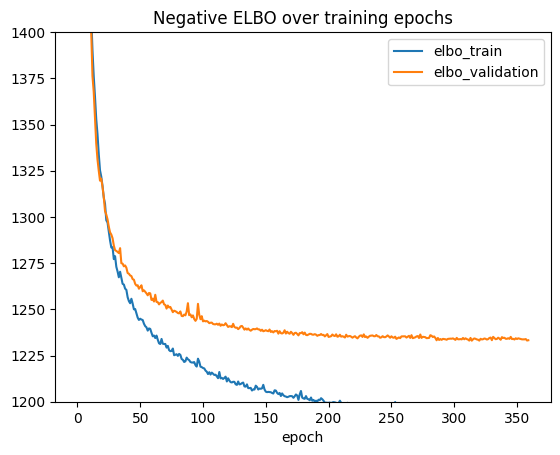

In [21]:
fig, ax = plt.subplots(1, 1)
vae.history["elbo_train"].plot(ax=ax, label="train")
vae.history["elbo_validation"].plot(ax=ax, label="validation")
ax.set(title="Negative ELBO over training epochs", ylim=(1200, 1400))
ax.legend()

In [22]:
rna = mdata.mod["rna_subset"]
protein = mdata.mod["protein"]
# arbitrarily store latent in rna modality
rna.obsm["X_totalVI"] = vae.get_latent_representation()

In [23]:
rna_denoised, protein_denoised = vae.get_normalized_expression(
    n_samples=25, return_mean=True
)

(
    rna.layers["denoised_rna"],
    protein.layers["denoised_protein"],
) = (rna_denoised, protein_denoised)

In [24]:
protein.layers[
    "protein_foreground_prob"
] = 100 * vae.get_protein_foreground_probability(
    n_samples=25, return_mean=True
)
parsed_protein_names = [p.split("_")[0] for p in protein.var_names]
protein.var["clean_names"] = parsed_protein_names
mdata.update()

In [38]:
sc.pp.neighbors(rna, use_rep="X_totalVI")
sc.tl.umap(rna)
sc.tl.leiden(rna, key_added="leiden_totalVI", resolution=0.2)

In [39]:
mdata.update()

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


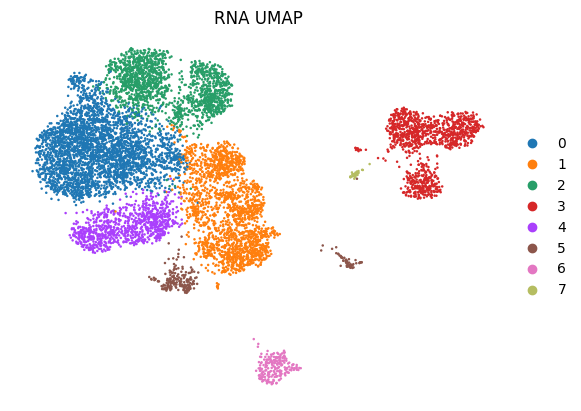

In [54]:
sc.pl.umap(rna, color=['leiden_totalVI'],title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=10)

In [41]:
mdata

MuData object with n_obs × n_vars = 9195 × 22094
  obs:	'_scvi_labels', '_scvi_batch'
  uns:	'_scvi_uuid', '_scvi_manager_uuid'
  3 modalities
    rna:	9195 x 22072
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'log1p', 'hvg'
      layers:	'counts'
    protein:	9195 x 38
      obs:	'_scvi_batch'
      var:	'clean_names'
      layers:	'denoised_protein', 'protein_foreground_prob'
    rna_subset:	9195 x 4000
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden_totalVI'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'log1p', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_totalVI_colors'
      obsm:	'X_totalVI', 'X_umap'
      layers:	'counts', 'denoised_rna'
      obsp:	'distances', 'connectivities'

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


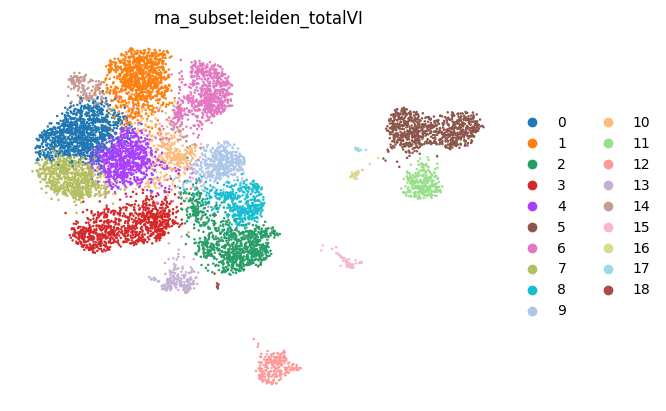

In [52]:
muon.pl.embedding(
    mdata,
    basis="rna_subset:X_umap",
    color="rna_subset:leiden_totalVI",
    frameon=False,
    ncols=1,
)

In [92]:
protein.var_names

Index(['41-BB', 'B7', 'CCR5', 'CCR6', 'CCR7', 'CD122', 'CD127', 'CD132',
       'CD14', 'CD16', 'CD161', 'CD19', 'CD25', 'CD27', 'CD28', 'CD3', 'CD38',
       'CD4', 'CD45RA', 'CD45RO', 'CD46', 'CD56', 'CD62L', 'CD8', 'CD9',
       'CTLA-4', 'CXCR3', 'CXCR4', 'HLADR', 'ICOS', 'LAG3', 'OX40', 'OX40L',
       'PD1', 'Slamf6', 'TIGIT', 'TIM3', 'gamma_delta'],
      dtype='object')

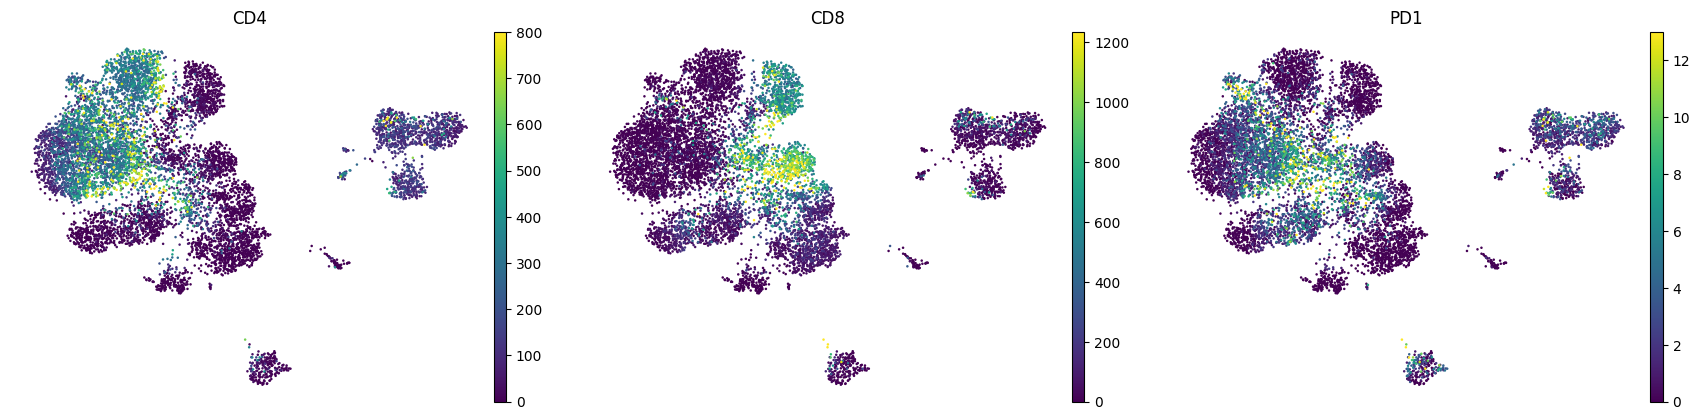

In [44]:
muon.pl.embedding(
    mdata,
    basis="rna_subset:X_umap",
    color=["protein:CD4","protein:CD8","protein:PD1"],
    frameon=False,
    ncols=3,
    vmax="p99",
    wspace=0.1,
    layer="denoised_protein",
)

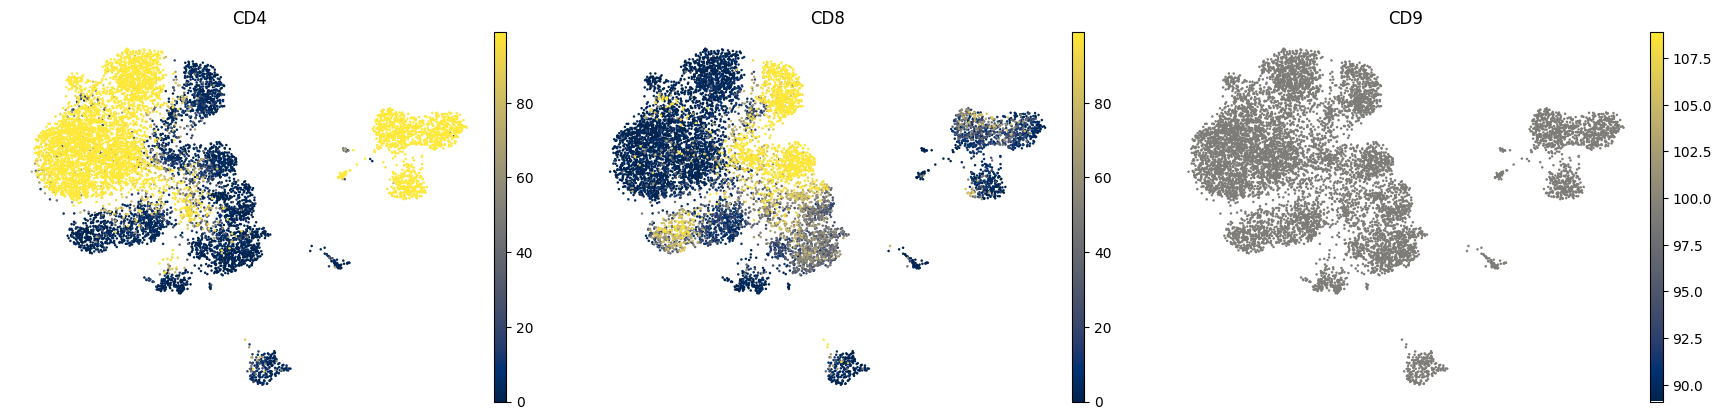

In [82]:
muon.pl.embedding(
    mdata,
    basis="rna_subset:X_umap",
    layer="protein_foreground_prob",
    color=["protein:CD4","protein:CD8","protein:CD9"],
    frameon=False,
    ncols=3,
    vmax="p99",
    wspace=0.1,
    color_map="cividis",
)

In [105]:
mdata.mod['rna_subset'].obs_names_make_unique()
mdata.mod['rna_subset'].var_names_make_unique()

In [55]:
mdata.update

<bound method MuData.update of MuData object with n_obs × n_vars = 9195 × 22094
  obs:	'_scvi_labels', '_scvi_batch', '_scvi_raw_norm_scaling'
  uns:	'_scvi_uuid', '_scvi_manager_uuid'
  3 modalities
    rna:	9195 x 22072
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'log1p', 'hvg'
      layers:	'counts'
    protein:	9195 x 38
      obs:	'_scvi_batch'
      var:	'clean_names'
      layers:	'denoised_protein', 'protein_foreground_prob'
    rna_subset:	9195 x 4000
      obs:	'n_gen

In [59]:
sc.tl.dendrogram(rna, groupby="leiden_totalVI", use_rep="X_totalVI")
# This is a bit of a hack to be able to use scanpy dendrogram with the protein data
protein.obs["leiden_totalVI"] = rna.obs["leiden_totalVI"]
protein.obsm["X_totalVI"] = rna.obsm["X_totalVI"]
sc.tl.dendrogram(protein, groupby="leiden_totalVI", use_rep="X_totalVI")

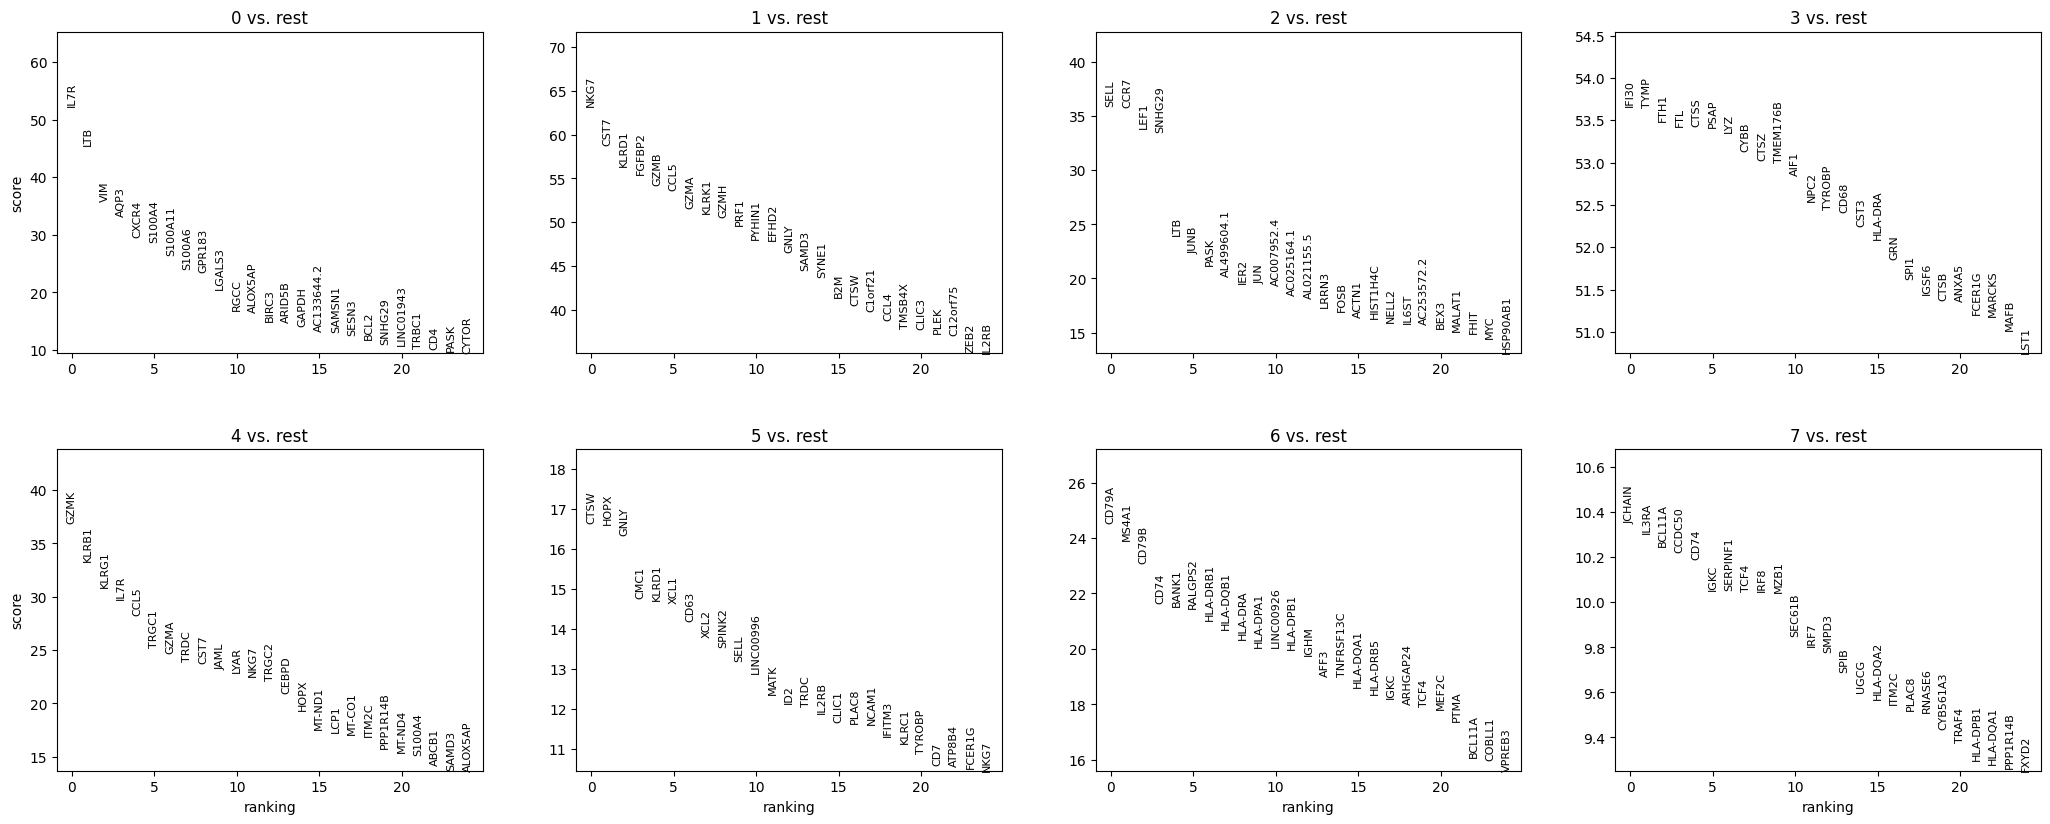

In [61]:
sc.tl.rank_genes_groups(rna, 'leiden_totalVI', method='wilcoxon')
sc.pl.rank_genes_groups(rna, n_genes=25, sharey=False)

In [63]:
#convert to dataframe
results = rna.uns['rank_genes_groups']
('0', '1', '2', '3', '4')

out = np.array([[0,0,0,0,0]])
for group in results['names'].dtype.names:
    out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['logfoldchanges'][group],
                                     np.array([group] * len(results['names'][group])).astype('object'))).T))



markers = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'lfc', 'cluster'])

markers = markers[(markers.pval_adj < 0.05) & (abs(markers.lfc) > 1)]

In [70]:
markers

,Gene,scores,pval_adj,lfc,cluster
0,IL7R,52.434303,0.0,2.416445,0
1,LTB,45.51815,0.0,1.903576,0
2,VIM,35.91235,0.0,1.100269,0
3,AQP3,33.261372,0.0,2.242444,0
4,CXCR4,29.495907,0.0,1.265194,0
...,...,...,...,...,...
31993,ZFP36L1,-5.154737,0.000005,-2.846888,7
31995,S100A11,-5.613787,0.0,-1.788745,7
31996,NEAT1,-6.200103,0.0,-1.750179,7
31997,IL7R,-6.614708,0.0,-4.126399,7


In [71]:
filtered_rna = {}
cats = rna.obs.leiden_totalVI.cat.categories
for i, c in enumerate(cats):
  filtered_rna[c] = markers[markers['cluster']==c]['Gene'].tolist()[:3]

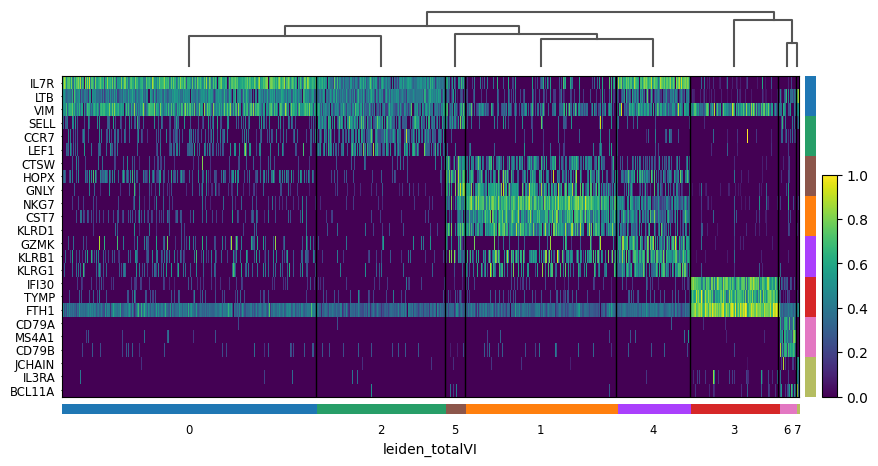

In [80]:
sc.pl.heatmap(
    rna,
    filtered_rna,
    groupby="leiden_totalVI",
    dendrogram=True,
    standard_scale="var",
    swap_axes=True,
)

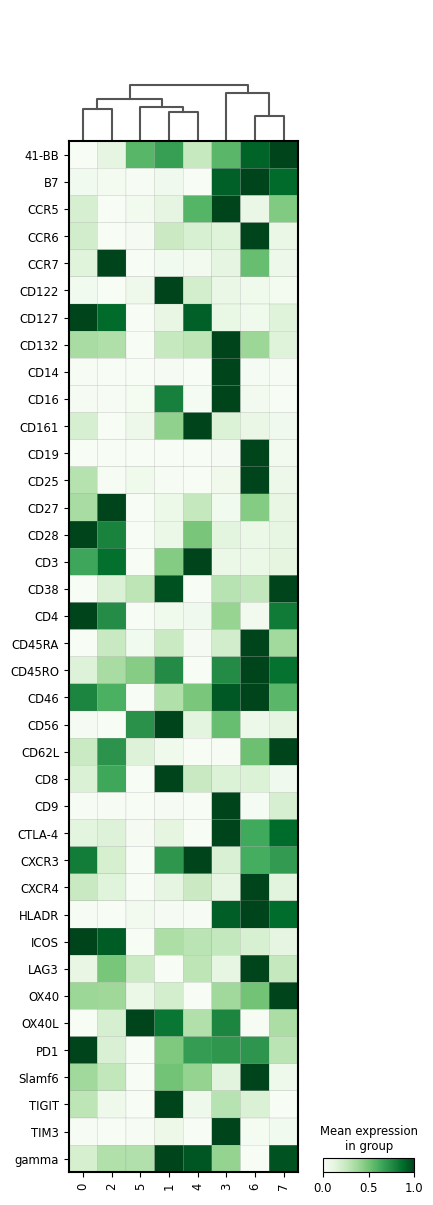

In [65]:
sc.pl.matrixplot(
    protein,
    protein.var["clean_names"],
    groupby="leiden_totalVI",
    gene_symbols="clean_names",
    dendrogram=True,
    swap_axes=True,
    layer="denoised_protein",
    cmap="Greens",
    standard_scale="var",
)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


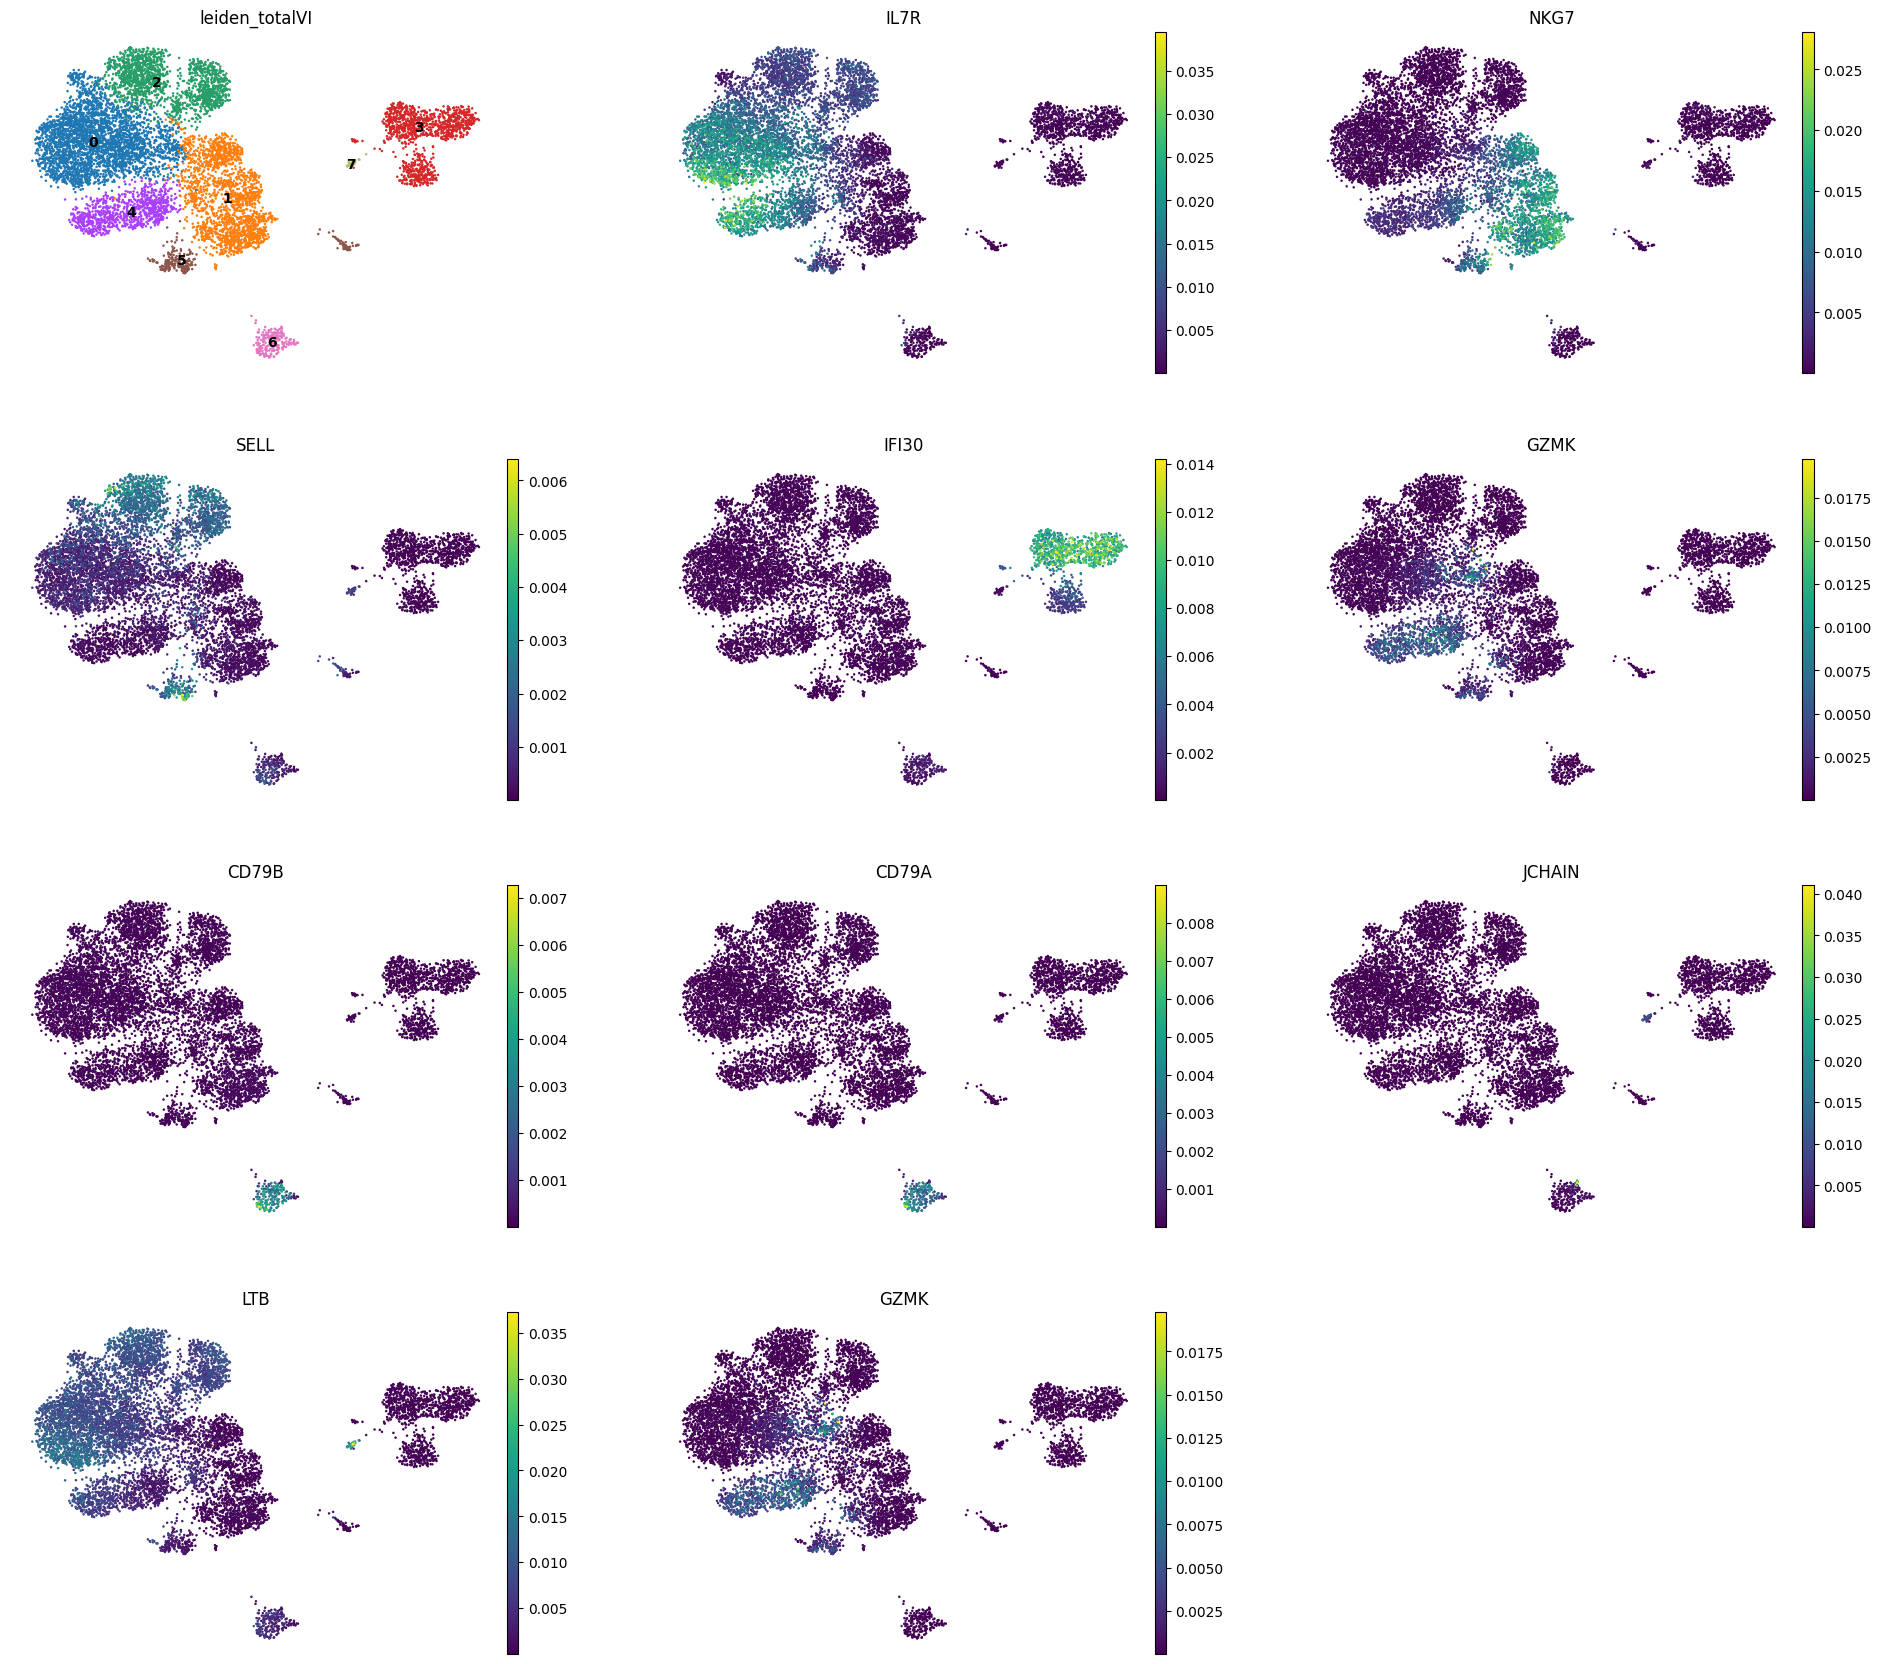

In [79]:
sc.pl.umap(
    rna,
    color=[
        "leiden_totalVI",
        "IL7R",
        "NKG7",
        "SELL",
        "IFI30",
        "GZMK",
        "CD79B",
        "CD79A",
        "JCHAIN",
        "LTB",
        "GZMK",
    ],
    legend_loc="on data",
    frameon=False,
    ncols=3,
    layer="denoised_rna",
    wspace=0.2,
)